In [84]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import subprocess
import os
from pathlib import Path


from dask.distributed import Client
client = Client()
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.01/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44115 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/44115/status,
Dashboard: /proxy/44115/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:45641,Workers: 7
Dashboard: /proxy/44115/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:34849,Total threads: 4
Dashboard: /proxy/36469/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:39193,


2024-05-25 23:10:16,848 - distributed.scheduler - ERROR - Couldn't gather keys: {('getitem-dc6bf84b9c814f782d9f801d733f5cce', 0): 'processing'}
2024-05-25 23:14:17,052 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-lat-1c7107eae367cd59b394458be28e7523' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x14930f1aa950>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=<xarray.backends.netCDF4_.NetCDF4ArrayWrapper object at 0x1491a1652640>, key=BasicIndexer((slice(None, None, None), slice(None, None, None)))))),),

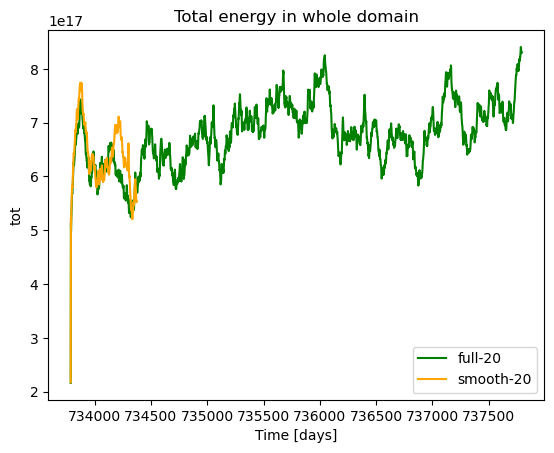

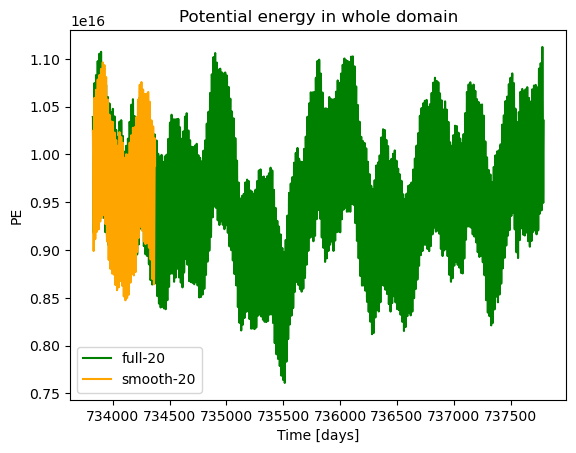

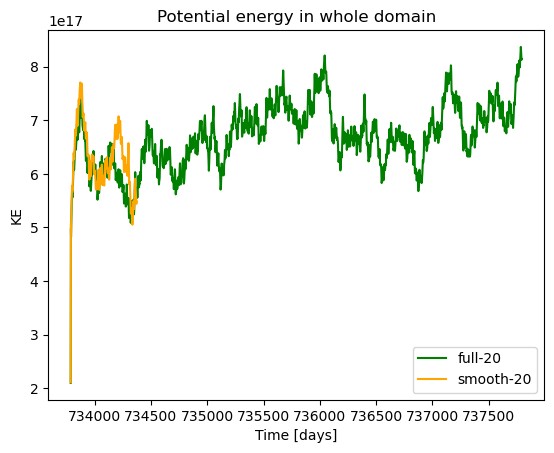

In [85]:
stats = {}
expts = ["full-20","smooth-20"]
for i in expts:
    try:
        temp = xr.open_mfdataset(
            [str(j) for j in (Path("/g/data/nm03/ab8992/outputs") / i).glob("output*/ocean_stats.nc")],decode_times = False
        )

        stats[i]  = xr.Dataset(
            {
                "KE": temp.KE.sum("Layer"),
                "PE": temp.APE.sum("Interface"),
                "tot": temp.KE.sum("Layer") + temp.APE.sum("Interface")
            }
        )
        # Modify Time coordinate of stats[i]


        # stats[i].coords["Time"][:].values -= 735600
    except Exception as e:
        print(i)
        print(e)
        pass
colours = ["green","orange","purple"]
for j,i in enumerate(expts):
    stats[i].tot.plot(label=i,color = colours[j])
    plt.title("Total energy in whole domain")
    plt.legend()
plt.figure()
for j,i in enumerate(expts):
    stats[i].PE.rolling(Time = 40).mean().plot(label=i,color = colours[j])
    plt.title("Potential energy in whole domain")
    plt.legend()
plt.figure()
for j,i in enumerate(expts):
    stats[i].KE.plot(label=i,color = colours[j])
    plt.title("Potential energy in whole domain")
    plt.legend()


In [3]:
for i,j in enumerate(["a","b"]):
    print(i,j)

0 a
1 b


## AFTER FIXING FROZEN SEA:

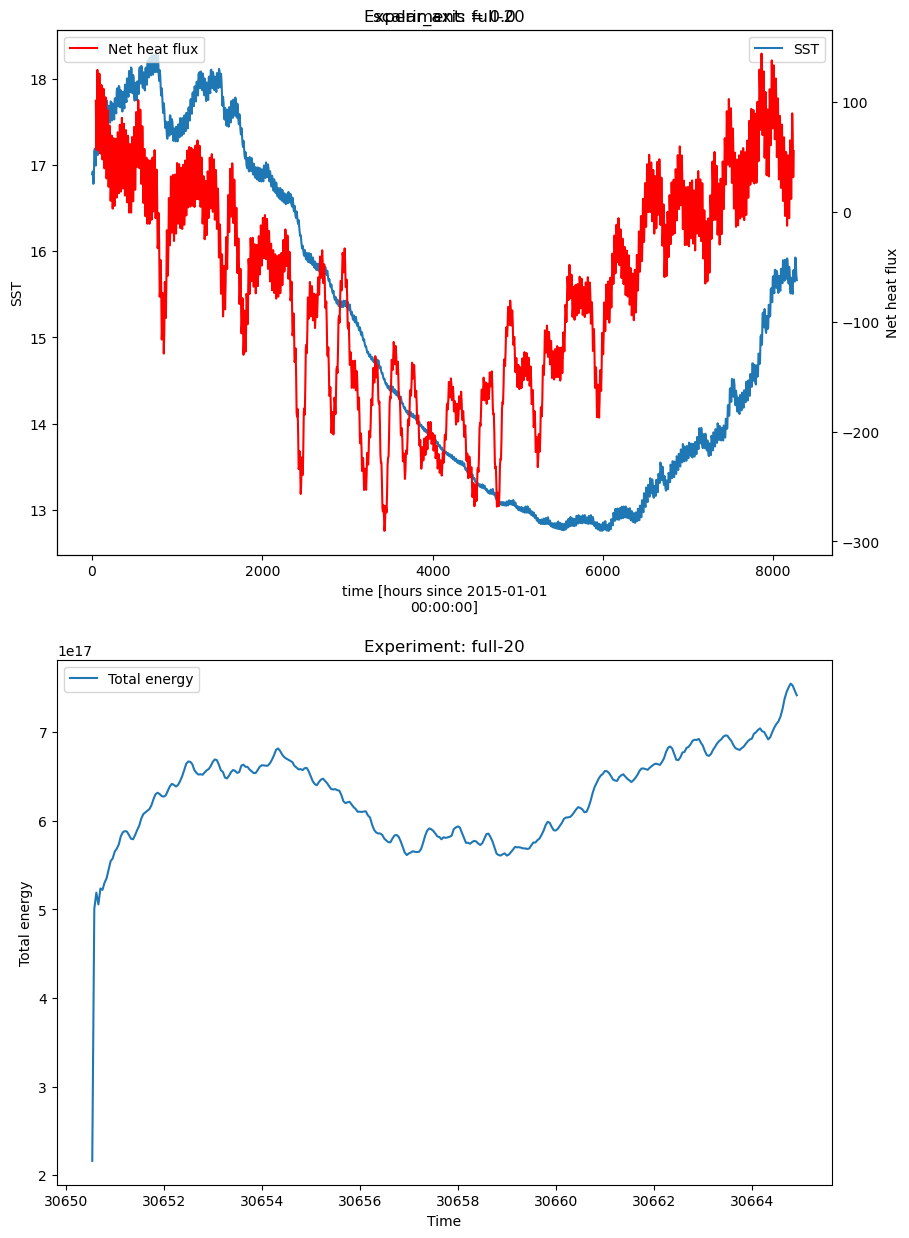

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


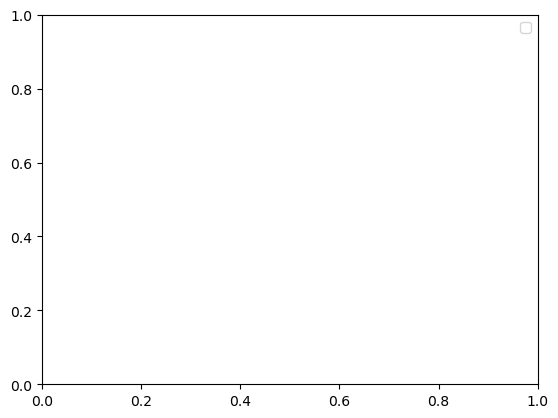

In [22]:
stats = {}
expts = ["full-20"]
for i in expts:
    try:
        temp = xr.open_mfdataset(
            [str(j) for j in (Path("/g/data/nm03/ab8992/outputs") / i).glob("output*/ocean_stats.nc")],decode_times = False
        )
        temp = temp.assign_coords({"Time":temp.Time/24})
        surface_flux = xr.open_mfdataset(
            [str(j) for j in (Path("/g/data/nm03/ab8992/outputs") / i).glob("output*/surface.nc")],decode_times = False
        )[["net_heat_surface_ga","sst_global"]]

        stats[i]  = xr.Dataset(
            {
                "KE": temp.KE.sum("Layer"),
                "PE": temp.APE.sum("Interface"),
                "tot": temp.KE.sum("Layer") + temp.APE.sum("Interface"),
                "net_heat": surface_flux.net_heat_surface_ga,
                "sst": surface_flux.sst_global
            }
        )
        # Modify Time coordinate of stats[i]


        # stats[i].coords["Time"][:].values -= 735600
    except Exception as e:
        print(i)
        print(e)
        pass
for i in expts:
    fig, ax = plt.subplots(2,figsize = (10,15))
    ax2 = ax[0].twinx()
    stats[i].tot.plot(ax=ax[1], label="Total energy")
    stats[i].net_heat.rolling(time=14, center=True).mean().plot(ax=ax2, label="Net heat flux",color = "red")
    stats[i].sst.plot(ax=ax[0], label="SST")

    ax[1].set_ylabel("Total energy")
    ax2.set_ylabel("Net heat flux")
    ax[0].set_ylabel("SST")

    ax[1].legend()
    ax2.legend()
    ax[0].legend()
    ax[0].set_title("Experiment: " + i)
    ax[1].set_title("Experiment: " + i)
    plt.show()
    plt.legend()

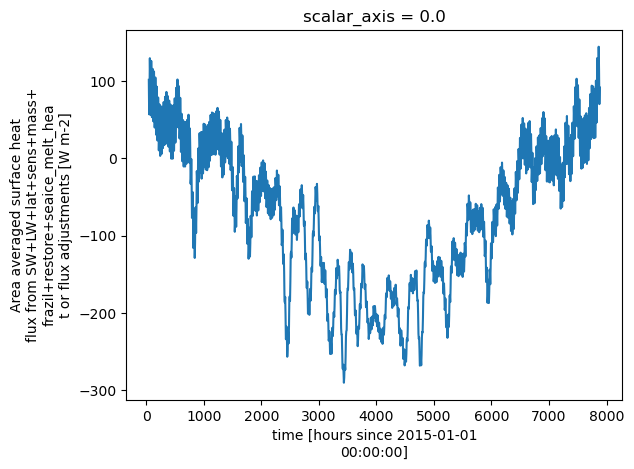

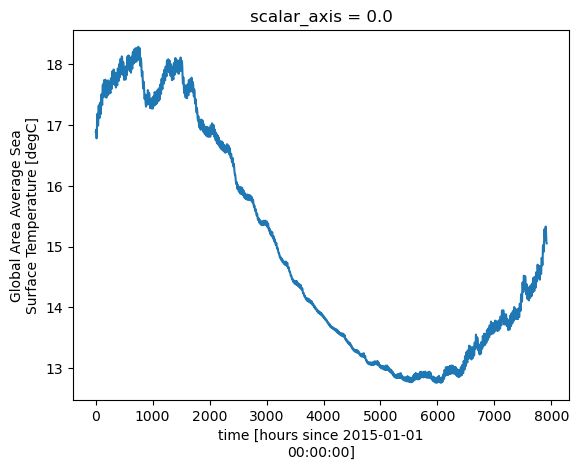

In [9]:
surface_flux = xr.open_mfdataset(
    [str(j) for j in (Path("/g/data/nm03/ab8992/outputs") / i).glob("output*/surface.nc")],decode_times = False
)[["net_heat_surface_ga","sst_global"]]


smoothed_flux = surface_flux.net_heat_surface_ga.rolling(time=14, center=True).mean()
smoothed_flux.plot()
plt.figure()
surface_flux.sst_global.plot()

In [7]:
surface_flux

<xarray.DataArray 'net_heat_surface_ga' (time: 1320, scalar_axis: 1)>
dask.array<concatenate, shape=(1320, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) float64 3.0 9.0 15.0 ... 7.905e+03 7.911e+03 7.917e+03
  * scalar_axis  (scalar_axis) float64 0.0
Attributes:
    units:          W m-2
    long_name:      Area averaged surface heat flux from SW+LW+lat+sens+mass+...
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT

0.3.0


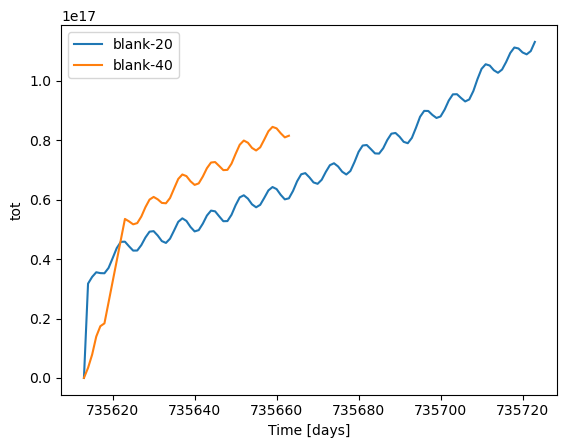

In [2]:
stats = {}
expts = ["blank-20","blank-40"]
for i in expts:
    try:
        temp = xr.open_mfdataset(
            [str(j) for j in (Path("/g/data/nm03/ab8992/outputs") / i).glob("output*/ocean_stats.nc")],decode_times = False
        )

        stats[i]  = xr.Dataset(
            {
                "KE": temp.KE.sum("Layer"),
                "PE": temp.APE.sum("Interface"),
                "tot": temp.KE.sum("Layer") + temp.APE.sum("Interface")
            }
        )
        # Modify Time coordinate of stats[i]


        # stats[i].coords["Time"][:].values -= 735600
    except Exception as e:
        print(i)
        print(e)
        pass
for i in expts:
    stats[i].tot.plot(label=i)

plt.legend()

## AFTER DEFROSTING

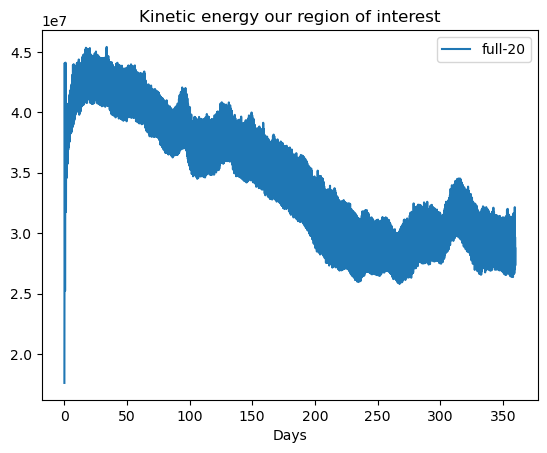

In [24]:
expts = ["full-20"]
# expts = ["blank-40"]


for i in expts:
    ke = xr.open_mfdataset(
        f"/g/data/nm03/ab8992/postprocessed/{i}/ke_timeseries.nc",decode_times = False,parallel=True
    ).to_dataarray()
    ke = ke.assign_coords({"time":ke.time/24})
    ke.plot(label = i)
plt.xlabel("Days")
plt.title("Kinetic energy our region of interest")
plt.legend()



## Spinup in our region only


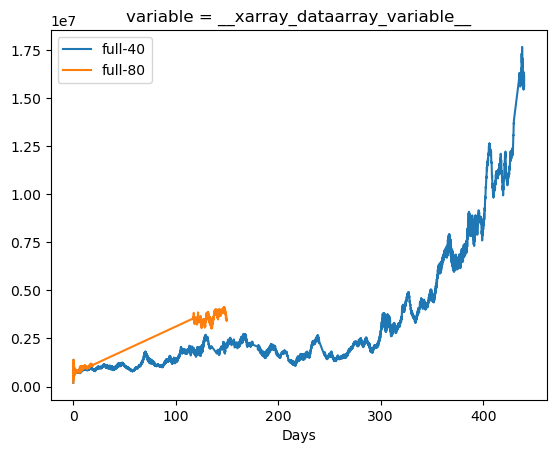

In [12]:
expts = ["full-40","full-80"]
# expts = ["blank-40"]


for i in expts:
    ke = xr.open_mfdataset(
        f"/g/data/nm03/ab8992/postprocessed/{i}/ke_timeseries.nc",decode_times = False,parallel=True
    ).to_dataarray()
    ke = ke.assign_coords({"time":ke.time/24})
    ke.plot(label = i)
plt.xlabel("Days")
plt.legend()



## M2 energy

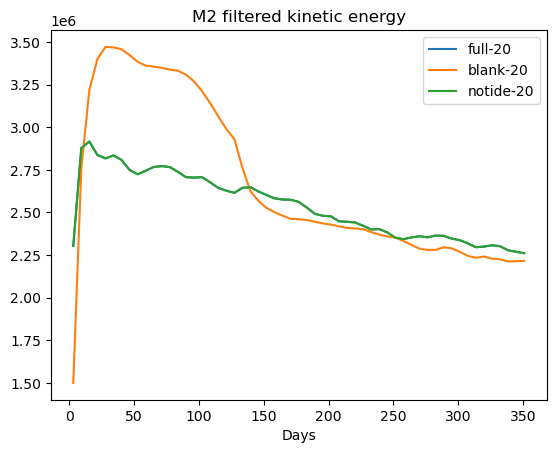

In [26]:
expts = ["full-20","full-40"]
expts = ["full-20","blank-20","notide-20"]


for i in expts:
    u = xr.open_mfdataset(
        f"/g/data/nm03/ab8992/postprocessed/{i}/UU/topdown/*.nc",decode_times = False,parallel=True
    ).UU
    v = xr.open_mfdataset(
        f"/g/data/nm03/ab8992/postprocessed/{i}/VV/topdown/*.nc",decode_times = False,parallel=True
    ).VV

    ke = 0.5*(u + v).integrate("yb").integrate("xb")

    ke = ke.assign_coords({"time":ke.time/24})
    ke.plot(label = i)

plt.title("M2 filtered kinetic energy")
plt.xlabel("Days")
plt.legend()



## AFTER DEFROSTING


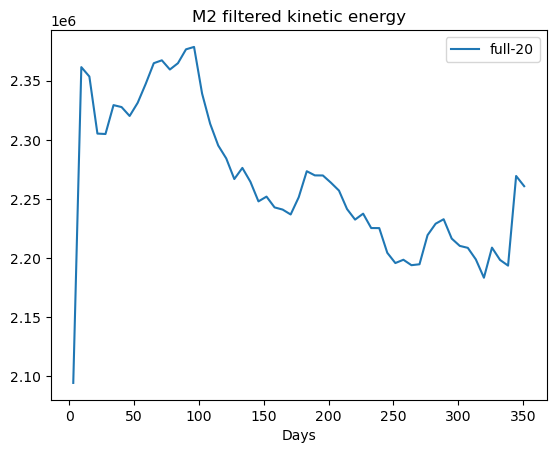

In [23]:
expts = ["full-20"]


for i in expts:
    u = xr.open_mfdataset(
        f"/g/data/nm03/ab8992/postprocessed/{i}/UU/topdown/*.nc",decode_times = False,parallel=True
    ).UU
    v = xr.open_mfdataset(
        f"/g/data/nm03/ab8992/postprocessed/{i}/VV/topdown/*.nc",decode_times = False,parallel=True
    ).VV

    ke = 0.5*(u + v).integrate("yb").integrate("xb")

    ke = ke.assign_coords({"time":ke.time/24})
    ke.plot(label = i)

plt.title("M2 filtered kinetic energy")
plt.xlabel("Days")
plt.legend()

